**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

# StarDist with object classification

The main purpose of StarDist is to detect all *object instances* in an input image, e.g. all cell nuclei in a fluorescence microscopy image as shown [here](https://github.com/stardist/stardist/tree/dev/examples/2D).

This notebook demonstrates how StarDist can additionally classify each found object instance into a fixed number of different *object classes* (e.g. cell types, phenotypes, etc.). We will refer to this as approach as **multi-class** in the following.

To use multi-class StarDist, one has to provide for every training input image `X` and associated label instance mask `Y` an additional **class dictionary** `cls_dict`, that maps instance ids to a discrete set of class labels `label_id -> (1,..., n_classes)`.

Difference to "normal" StarDist training:

* Set the `n_classes` variable to the number of object classes in the `Config` object.
* Set the `classes` variable in `model.train` to a list of class dictionaries for every training image/label pair.

In the following we demonstrate this workflow for the case of a synthetic dataset consisting of 2 cell phenotypes of different texture.

**NOTE:** Although this example uses 2D images, the demonstrated functionality also works for 3D StarDist.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label


np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20

def plot_img_label(img, lbl, cls_dict, n_classes=2, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    class_img[...,:3][res==0] = 0 
    class_img[...,-1][res==0] = 1
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(class_img)
    ac.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

In [2]:
# set the number of object classes
n_classes = 2

In [3]:
# generate synthetic samples of 2D images, label masks, and class dicts 

def generate_sample(n=256):
    from scipy.ndimage import distance_transform_edt
    from skimage.segmentation import watershed, relabel_sequential 
    from skimage.morphology import disk, binary_erosion, binary_closing
    from scipy import ndimage as ndi
    m = np.random.randint(10,30)
    center = tuple(np.random.randint(0,n,(2,m)))
    markers = np.zeros((n,n),np.uint16)
    markers[center] = np.random.permutation(np.arange(1,m+1))
    
    dist = distance_transform_edt(1-1*(markers>0)) + 4*ndi.zoom(np.random.uniform(0,1,(n//16,n//16)), (16,16), order=1)
    dist *= np.random.uniform(1,2)
    y = watershed(dist, markers, mask=np.exp(-.1*dist)>.1)
        
    y = relabel_sequential(np.max(np.stack([i*binary_closing(y==i,disk(3)) for i in np.unique(y[y>0])],axis=0),axis=0))[0]

    ind = np.arange(1,y.max()+1)
    np.random.shuffle(ind)
    c1, c2 = ind[:len(ind)//2], ind[len(ind)//2:]
    m1 = np.isin(y,c1)
    m2 = np.isin(y,c2)    
    
    x =  ndi.gaussian_filter((y>0).astype(np.float32),2)
        
    noise1 = ndi.zoom(np.random.uniform(0,1,(n//4,n//4)), (4,4), order=3)
    noise2 = ndi.zoom(np.random.uniform(0,1,(n//16,n//16)), (16,16), order=3)
    x[m1] = .2*(1+np.sin(y[m1]))+noise1[m1]
    x[m2] = .2*(1+np.sin(y[m2]))+noise2[m2]
    x = ndi.gaussian_filter(x,1)+2*ndi.gaussian_filter(x,20)
    gain = 100 
    x = np.random.poisson((1+gain*x).astype(int))/gain
    x += .08*np.random.normal(0,1,x.shape)
    cls = dict((i,1 if i in c1 else 2) for i in range(1,m+1))
    return x, y, cls

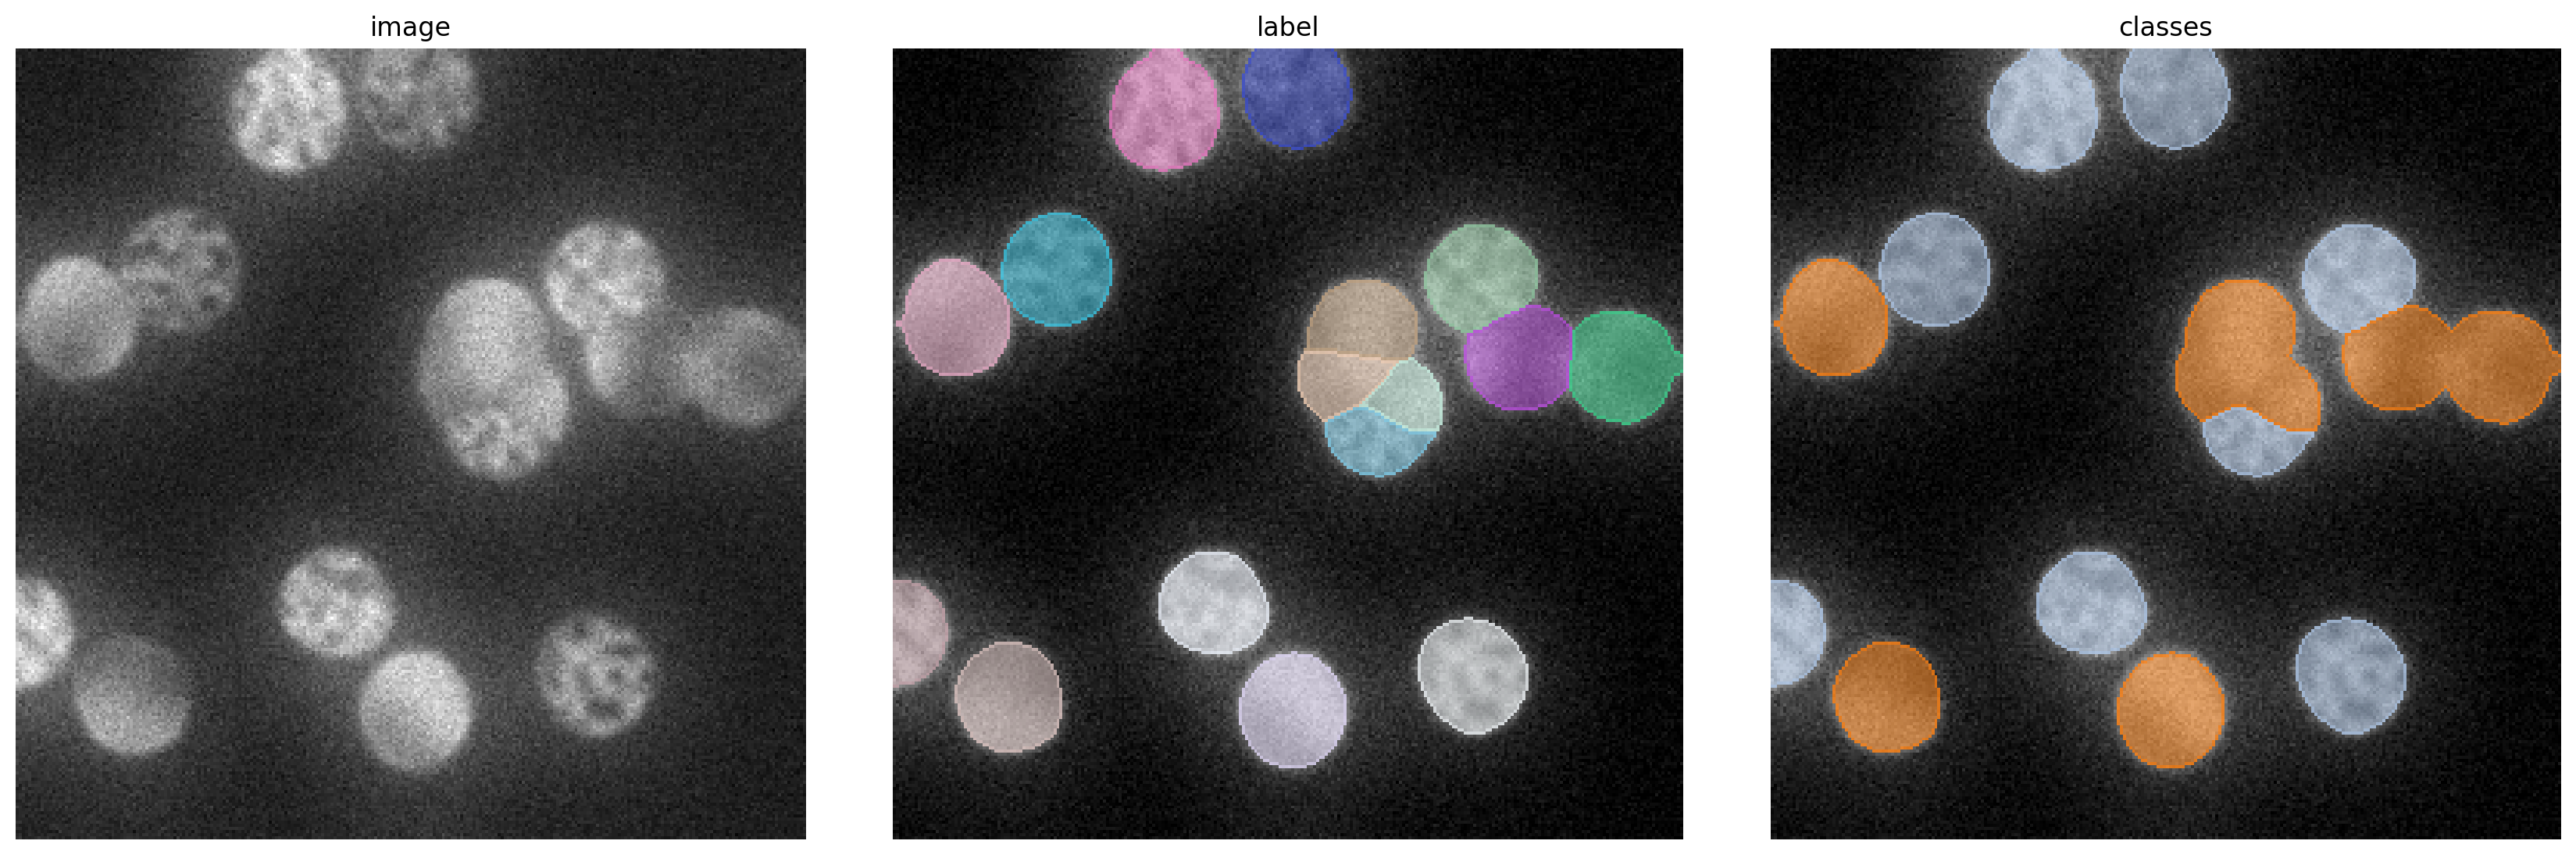

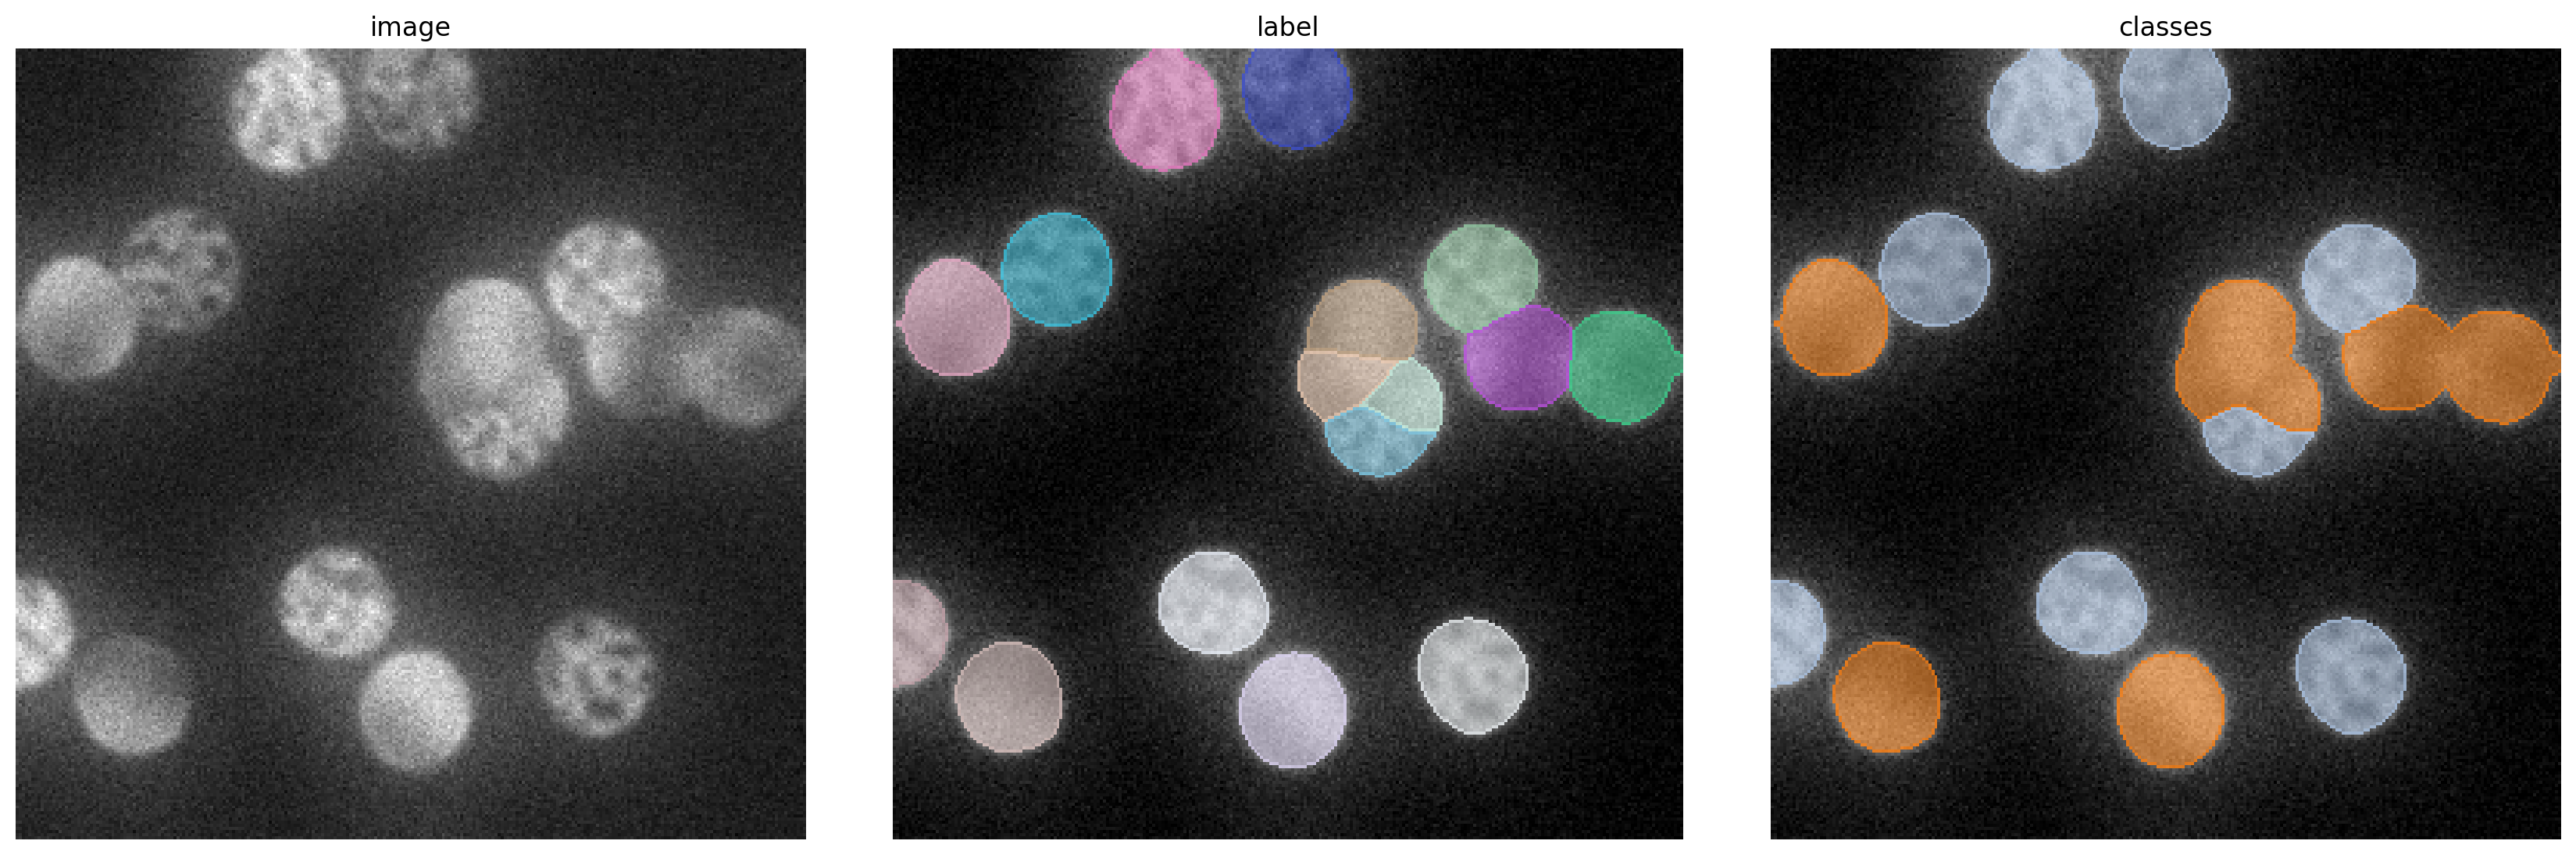

In [5]:
# plot an example 
np.random.seed(42)
x,y,cls_dict = generate_sample()

ax = plot_img_label(x,y,cls_dict, n_classes=n_classes)
for a in ax: a.axis("off");
plt.show()

In [6]:
# show the cls_dict for this example. {label_id -> class_number}
print(cls_dict)

{1: 2, 2: 1, 3: 1, 4: 2, 5: 1, 6: 2, 7: 1, 8: 1, 9: 1, 10: 2, 11: 1, 12: 1, 13: 2, 14: 2, 15: 2, 16: 2}


Generate a synthetic training set of 100 random images, label masks, and class dictionaries.

In [10]:
X, Y, C = tuple(zip(*tuple(generate_sample() for _ in tqdm(range(100))))) #X = images; Y = instance labels; C = dictionary of instance labels and class labels

assert len(X) == len(Y) == len(C)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.18it/s]


In [11]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [12]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 411.79it/s]


Split into train and validation datasets.

In [13]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, C_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val] , [C[i] for i in ind_val]
X_trn, Y_trn, C_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train],  [C[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 100
- training:        85
- validation:      15


Training data consists of pairs of input image and label instances.

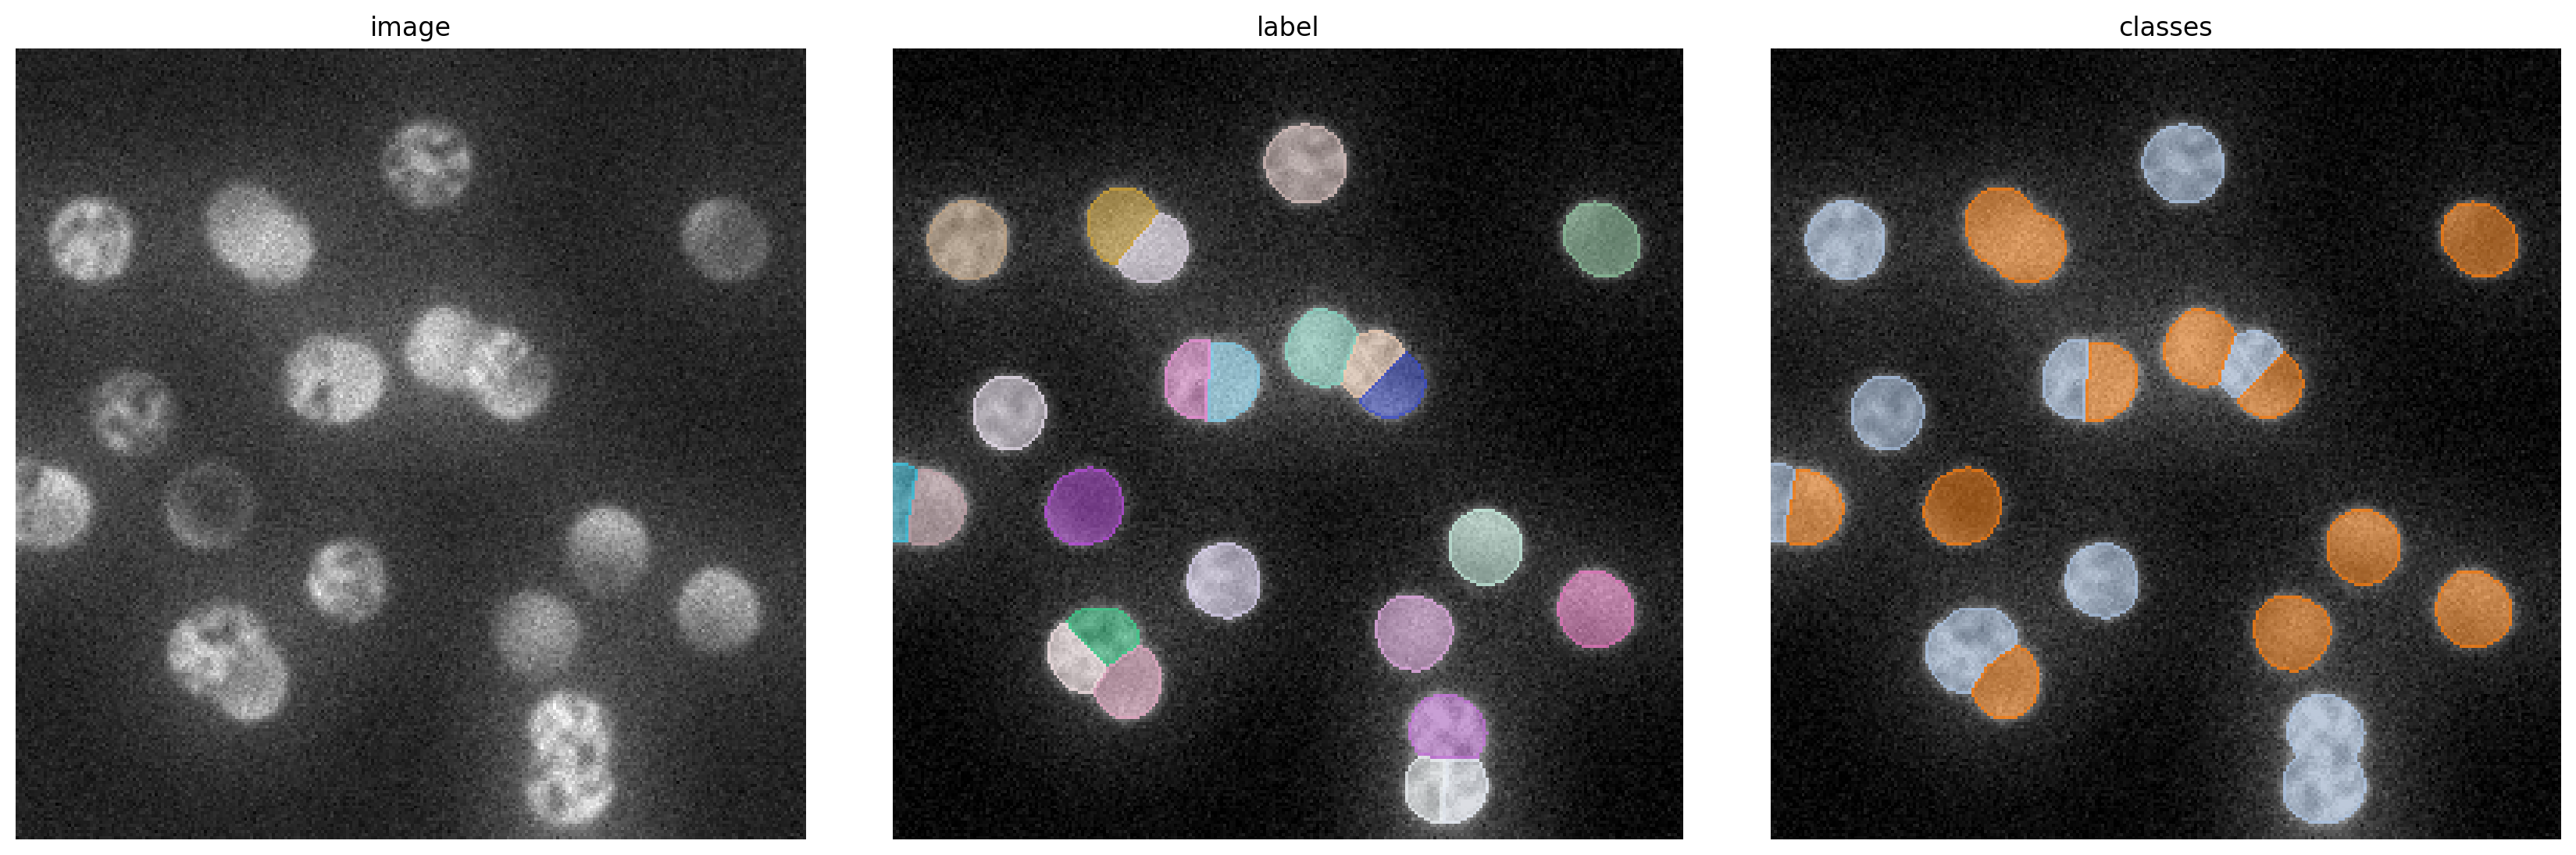

In [16]:
i = min(8, len(X)-1)
img, lbl, cls = X[i], Y[i], C[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl, cls)
plt.show()
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [11]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

### Multi-class model

* Set the `n_classes` variable to the number of object classes in the `Config` object.
* Set the `classes` variable in `model.train` to a list of class dictionaries for every training image/label pair.

In [17]:
# 32 is a good default choice
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    n_classes    = n_classes,   # set the number of object classes
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=2, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2, 1), train_class_weights=(1, 1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': 2,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2, 1),
 'train_class_weights': (1, 1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.000

In [18]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)
    # alternatively, adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    # limit_gpu_memory(0.8)    

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [19]:
model = StarDist2D(conf, name='stardist_multiclass', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [20]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 1))


median object size:      [24.5 25. ]
network field of view :  [93 94]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [21]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [22]:
# plot some augmented examples
img, lbl, cls = X[0], Y[0], C[0]
plot_img_label(img,lbl,cls, n_classes=n_classes)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug,lbl_aug,cls, img_title="image augmented", lbl_title="label augmented", n_classes=n_classes)
None;

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [23]:
model.train(X_trn,Y_trn, classes=C_trn, validation_data=(X_val,Y_val,C_val), augmenter=augmenter,
            epochs=200) # 200 epochs seem to be enough for synthetic demo dataset

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - dist_dist_iou_metric: 0.0843 - dist_loss: 10.2984 - dist_relevant_mae: 10.2981 - dist_relevant_mse: 154.6438 - loss: 3.2890 - prob_class_loss: 0.7889 - prob_kld: 0.3540 - prob_loss: 0.4404 - val_dist_dist_iou_metric: 0.4172 - val_dist_loss: 5.7418 - val_dist_relevant_mae: 5.7706 - val_dist_relevant_mse: 53.2068 - val_loss: 1.8700 - val_prob_class_loss: 0.4914 - val_prob_kld: 0.1411 - val_prob_loss: 0.2223 - learning_rate: 3.0000e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - dist_dist_iou_metric: 0.3960 - dist_loss: 5.7795 - dist_relevant_mae: 5.7783 - dist_relevant_mse: 55.4692 - loss: 1.8825 - prob_class_loss: 0.4987 - prob_kld: 0.1422 - prob_loss: 0.2279 - val_dist_dist_iou_metric: 0.4276 - val_dist_loss: 5.4900 - val_dist_relevant_mae: 5.5093 - val_dist_relevant_mse: 49.7542 - val_loss: 1.4897 - val_prob_class_loss: 0.2527 - val_prob_kld: 0.0528 - val_prob_loss: 0.1340 - learning_rate: 3.0000e-04
Epoch 3/200
1

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [19]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:00<00:00, 16.13it/s, 0.732 -> 0.954]


Using optimized values: prob_thresh=0.732477, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.7324770065459176, 'nms': 0.4}

# Evaluation and Detection Performance

Predict for a single example image first.

In [20]:
i = 8
label, res = model.predict_instances(X_val[i], n_tiles=model._guess_n_tiles(X_val[i]))

In [21]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 

def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict

print(class_from_res(res))

{1: 1, 2: 1, 3: 2, 4: 2, 5: 1, 6: 1, 7: 1, 8: 2, 9: 1, 10: 2, 11: 1, 12: 2, 13: 1, 14: 1, 15: 1, 16: 2, 17: 2, 18: 2, 19: 1, 20: 2, 21: 2, 22: 1, 23: 2, 24: 2, 25: 2, 26: 1, 27: 2, 28: 1}


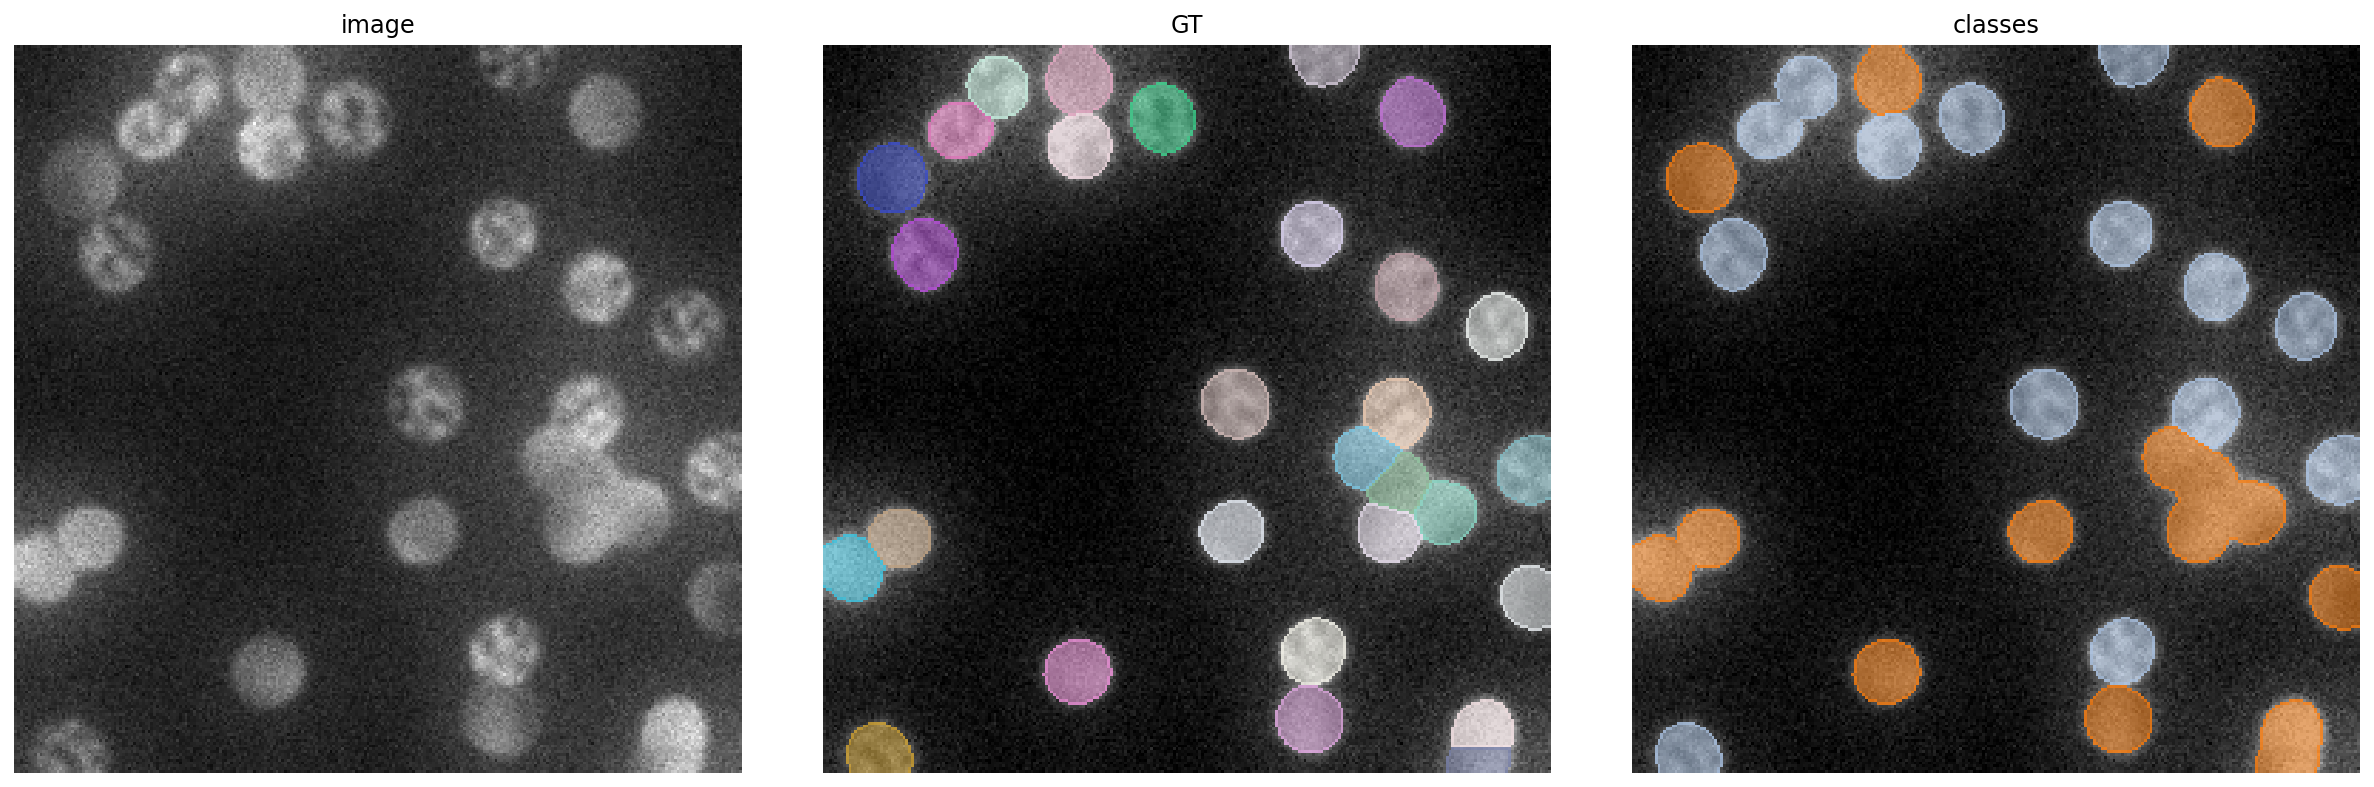

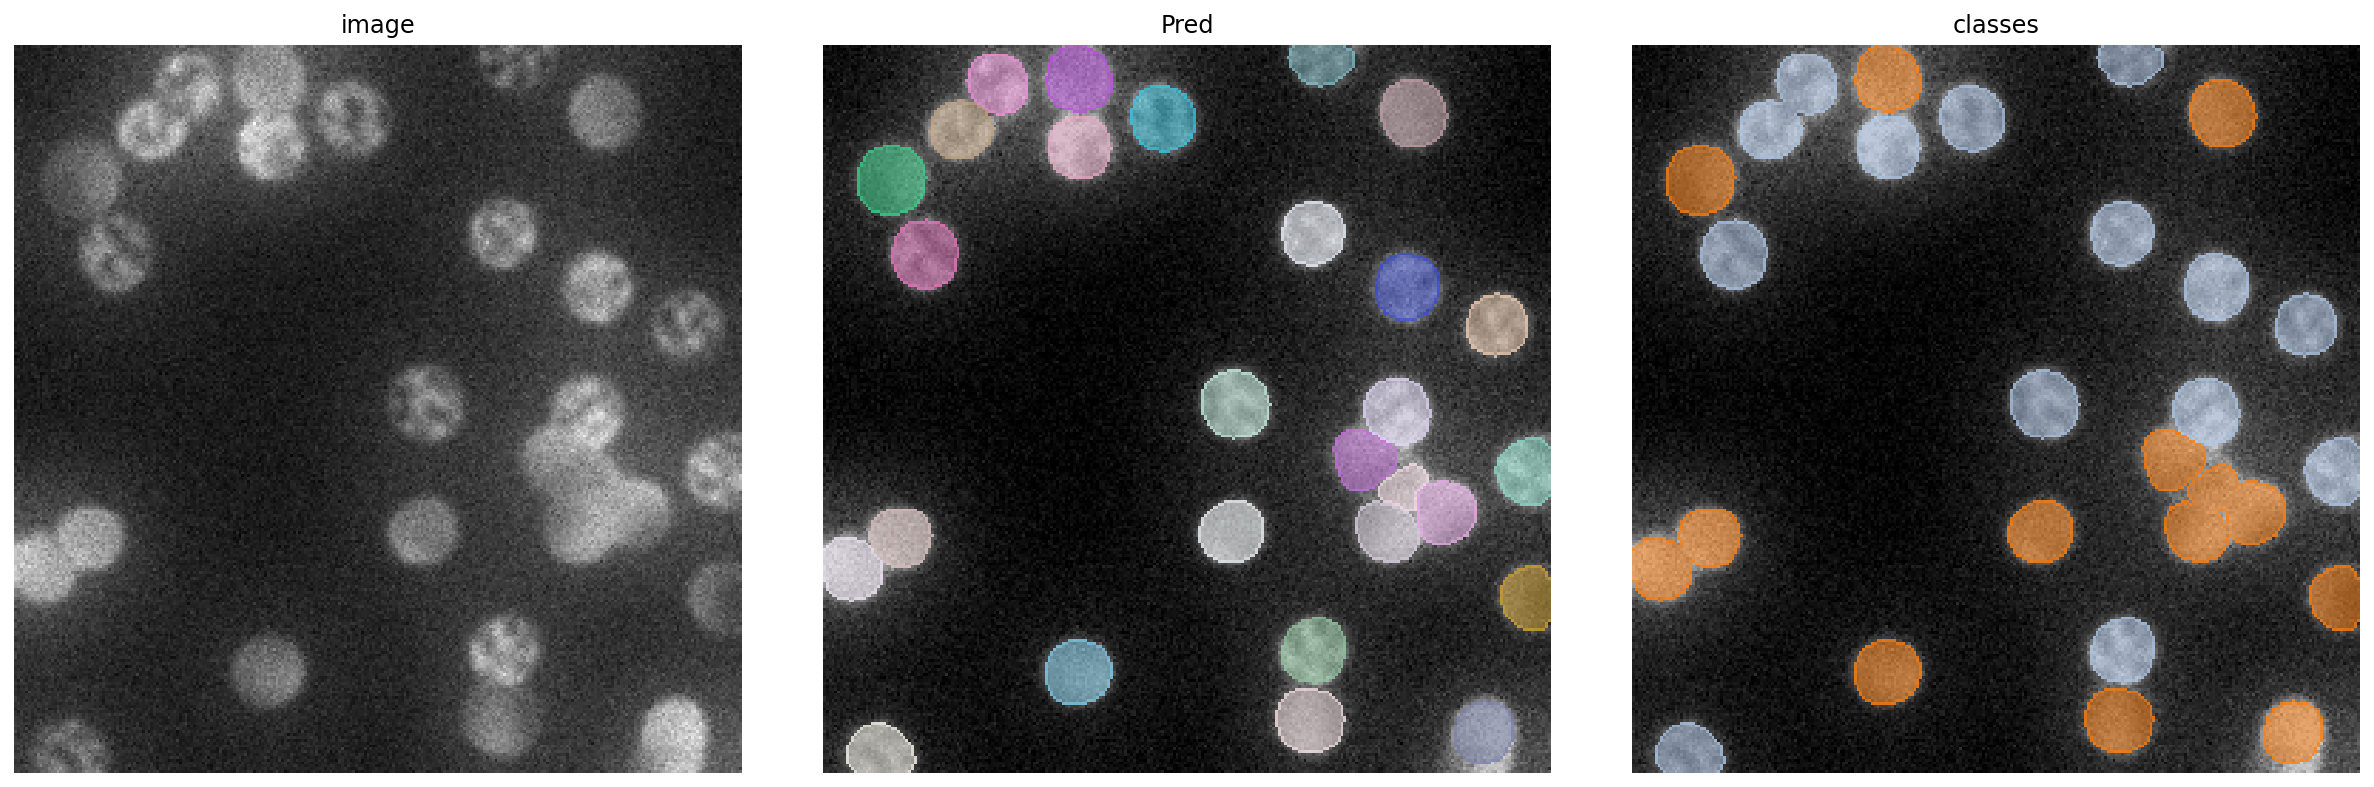

In [22]:
plot_img_label(X_val[i], Y_val[i], C_val[i],            lbl_title="GT")
plot_img_label(X_val[i], label,    class_from_res(res), lbl_title="Pred");

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

First predict the labels for all validation images:

In [23]:
Y_val_pred, res_val_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_val[:])]))

100%|██████████| 15/15 [00:00<00:00, 36.30it/s]


Plot another GT/prediction example 

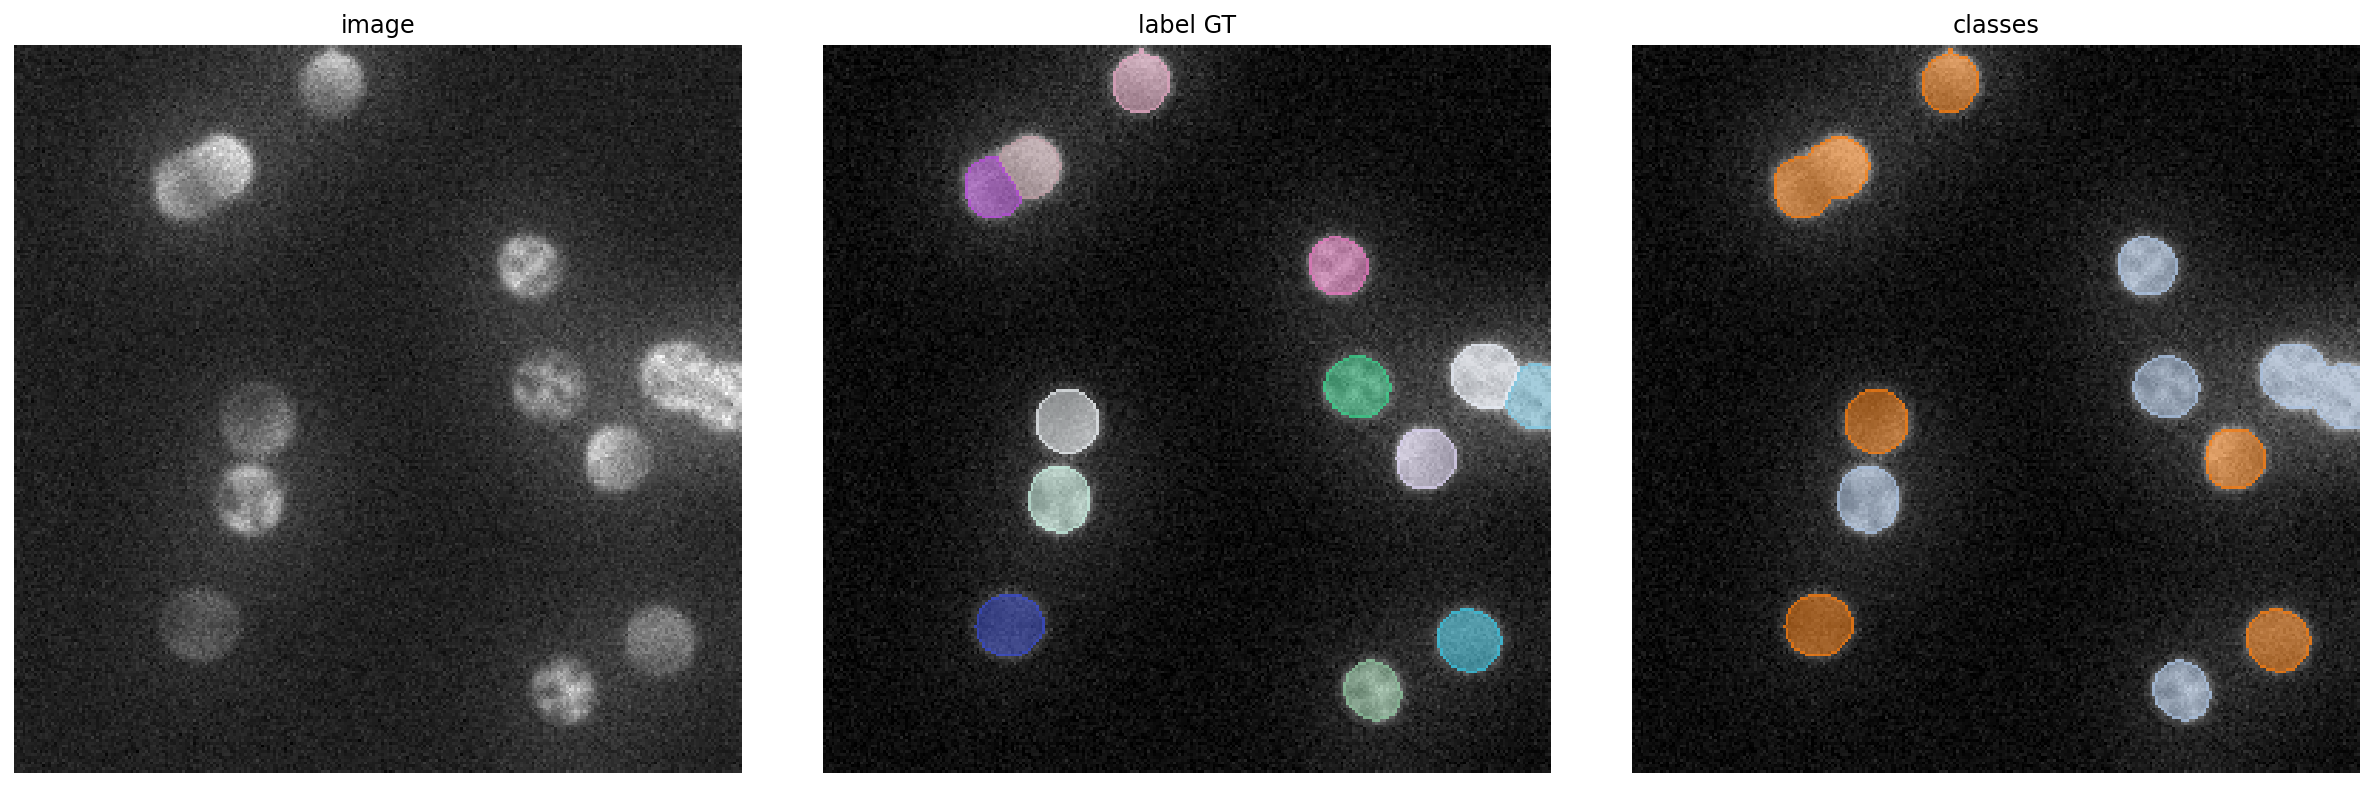

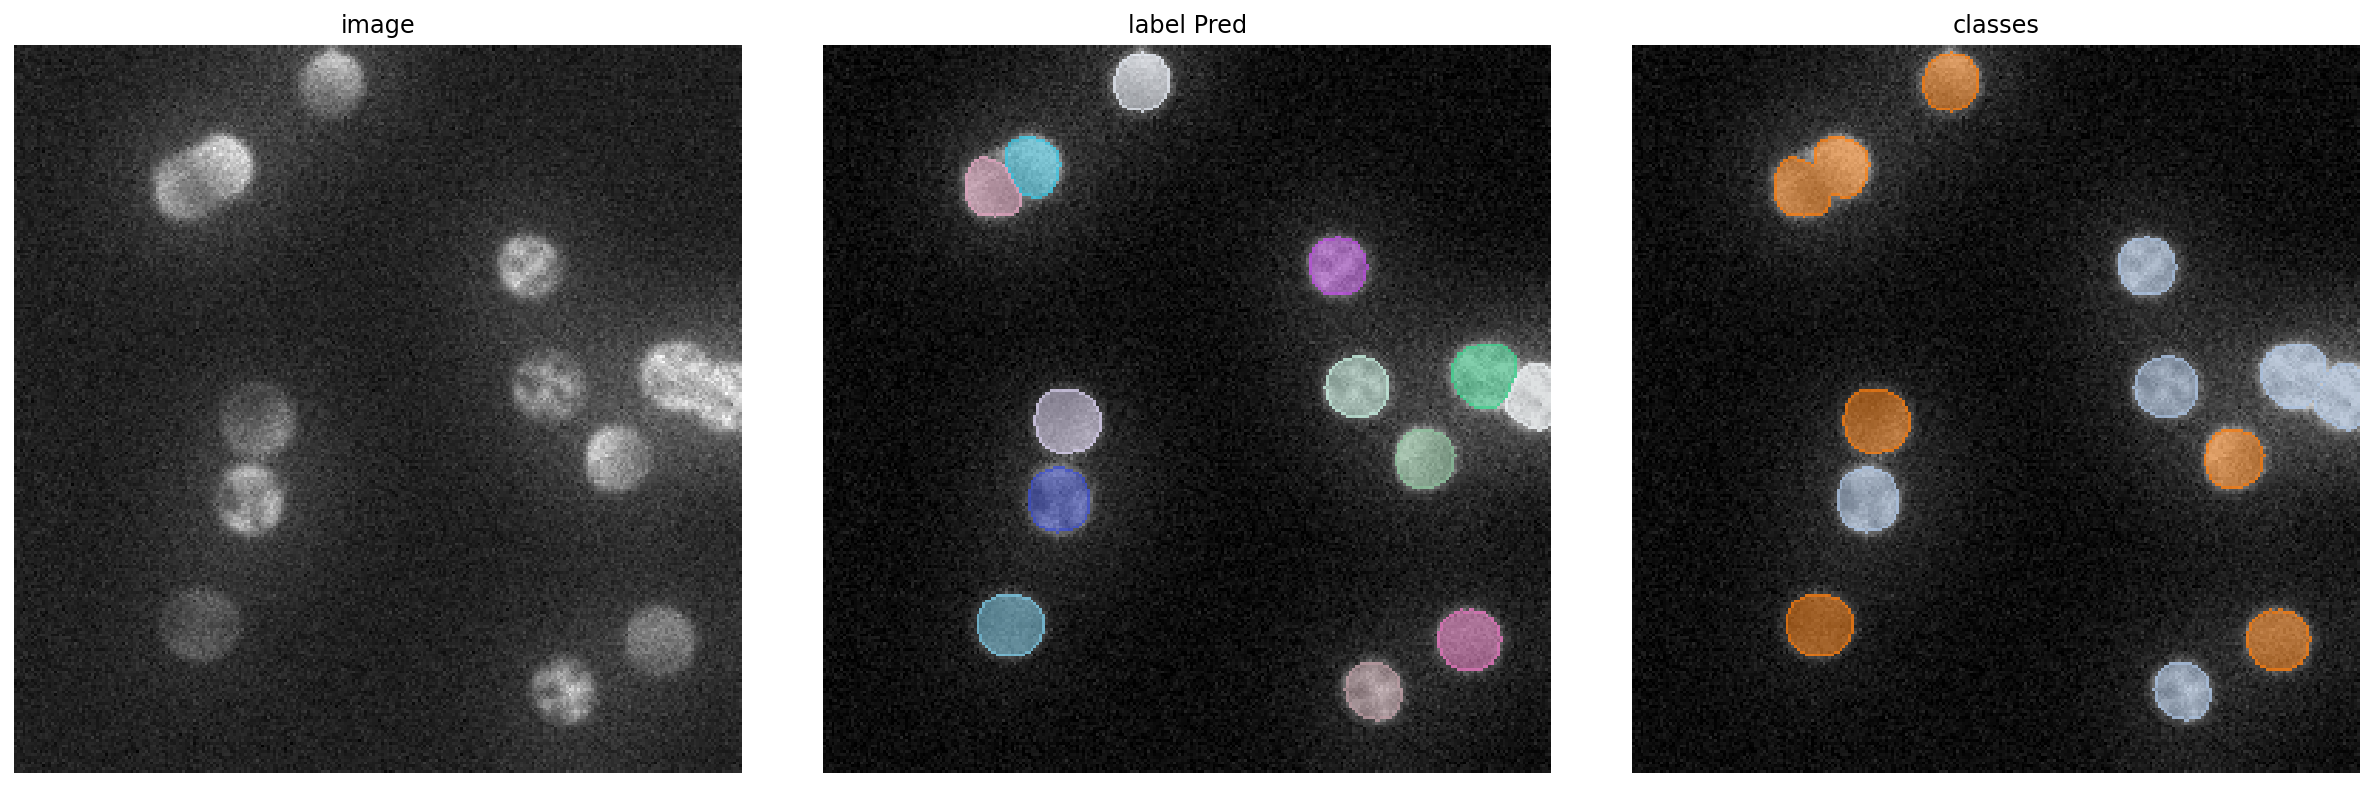

In [24]:
i = 10
plot_img_label(X_val[i],Y_val[i],      C_val[i],                        lbl_title="label GT")
plot_img_label(X_val[i],Y_val_pred[i], class_from_res(res_val_pred[i]), lbl_title="label Pred");

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [25]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:00<00:00, 38.59it/s]


Example: Print all available matching statistics for $\tau=0.5$

In [26]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=2, tp=278, fn=10, precision=0.9928571428571429, recall=0.9652777777777778, accuracy=0.9586206896551724, f1=0.9788732394366197, n_true=288, n_pred=280, mean_true_score=0.8914246526029375, mean_matched_score=0.9234902875886547, panoptic_quality=0.9039799294001619, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

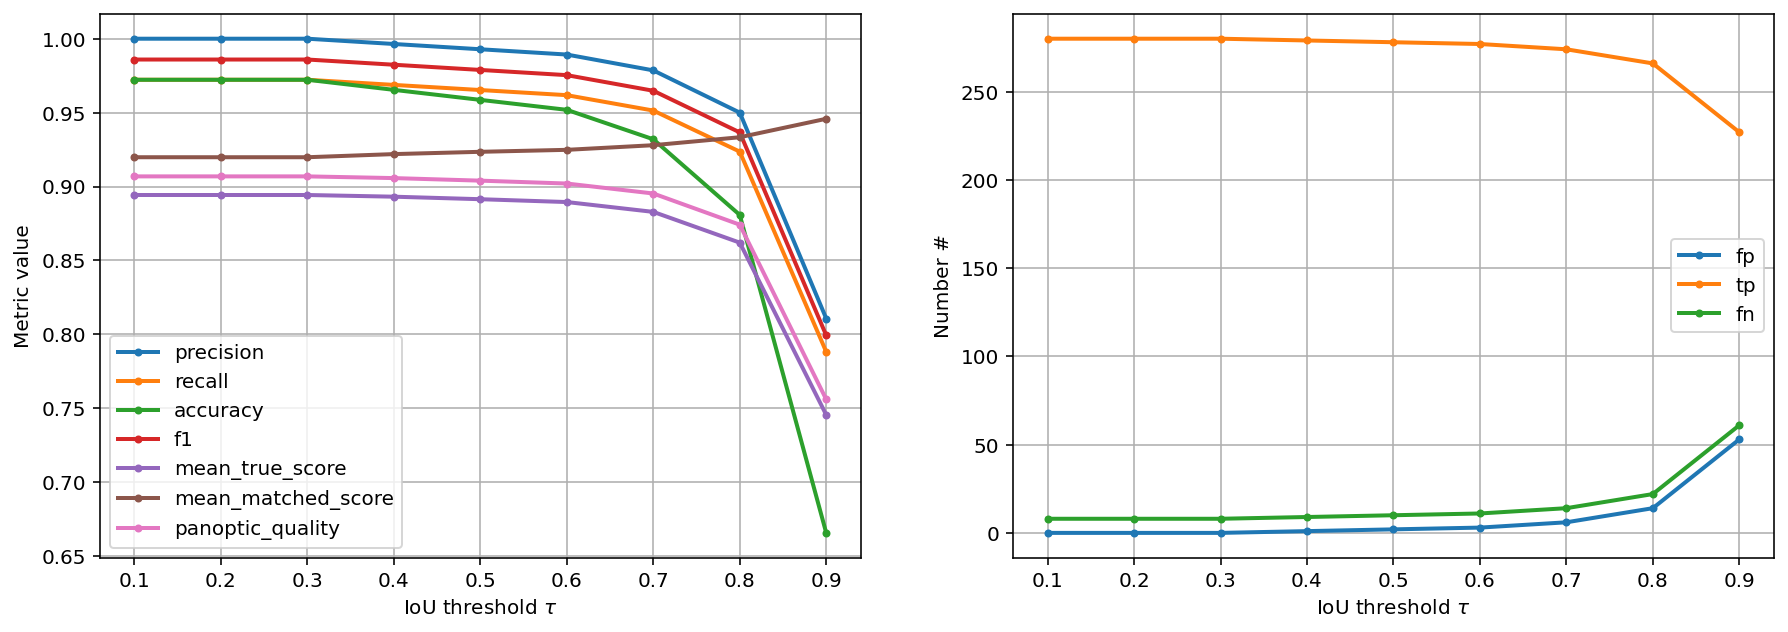

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();